In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load dataset

In [4]:
# (train_ds, val_ds), ds_info = tfds.load(
#     'cats_vs_dogs',
#     split=['train[:80%]', 'train[80%:]'],
#     as_supervised=True,
#     with_info=True
# )

import os
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
import zipfile



with zipfile.ZipFile(r"G:\MY PROJECTS\TENSORFLOW\Transfer Learning with MobileNet\kagglecatsanddogs_5340.zip", 'r') as zip_ref:

    zip_ref.extractall()
from os import listdir
listdir(r"G:\MY PROJECTS\TENSORFLOW\Fine Tune InceptionV3\PetImages")
#filter out corrupted images
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0  269k    0     0  1190k      0  0:11:16 --:--:--  0:11:16 1197k
  0  786M    0 2563k    0     0  2082k      0  0:06:26  0:00:01  0:06:25 2084k
  0  786M    0 5072k    0     0  2278k      0  0:05:53  0:00:02  0:05:51 2279k
  0  786M    0 7638k    0     0  2366k      0  0:05:40  0:00:03  0:05:37 2367k
  1  786M    1 9988k    0     0  2361k      0  0:05:41  0:00:04  0:05:37 2361k
  1  786M    1 12.8M    0     0  2506k      0  0:05:21  0:00:05  0:05:16 2566k
  1  786M    1 15.5M    0     0  2560k      0  0:05:14  0:00:06  0:05:08 2678k
  2  786M    2 18.5M    0     0  2620k      0  0:05:07  0:00:07  0:05:00 2773k
  2  786M    2 21.6M    0     0  2697k      0  0:04:58  0:00:08  0:04:50 2911k
  3  786M    3 24.8M    0     0  2755k      0  0:04

Deleted 1578 images.


# Preprocess and resize images to match InceptionV3 input

In [12]:
from tensorflow.keras.utils import image_dataset_from_directory

data_dir = r"G:\MY PROJECTS\TENSORFLOW\Fine Tune InceptionV3\PetImages"
batch_size = 32
img_size = (160, 160)
seed = 123

# Load training and validation datasets from the filtered local directory
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

IMG_SIZE = 299
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))        # Resize to 299x299
    image = preprocess_input(image)                             # InceptionV3 preprocessing
    return image, label
 
train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


# Load InceptionV3 base model with ImageNet weights (exclude top classifier)

In [13]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base initially

# Add custom classification head

In [14]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),                # Reduce dimensions
    layers.Dense(128, activation='relu'),           # Custom dense layer
    layers.Dropout(0.5),                            # Add regularization
    layers.Dense(1, activation='sigmoid')           # Binary output
])

# Compile the model

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train initial frozen model

In [16]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 1526s 3s/step - accuracy: 0.9717 - loss: 0.0762 - val_accuracy: 0.9915 - val_loss: 0.0277
Epoch 2/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 1486s 3s/step - accuracy: 0.9903 - loss: 0.0340 - val_accuracy: 0.9904 - val_loss: 0.0270
Epoch 3/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 1484s 3s/step - accuracy: 0.9905 - loss: 0.0308 - val_accuracy: 0.9908 - val_loss: 0.0276


# Unfreeze top layers of base model for fine-tuning
                        

In [17]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False # Only fine-tune last 50 layers

# Recompile with lower learning rate

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training (fine-tuning)

In [19]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 1828s 3s/step - accuracy: 0.9782 - loss: 0.0672 - val_accuracy: 0.9908 - val_loss: 0.0320
Epoch 2/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 1930s 3s/step - accuracy: 0.9938 - loss: 0.0207 - val_accuracy: 0.9908 - val_loss: 0.0332
Epoch 3/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 1766s 3s/step - accuracy: 0.9962 - loss: 0.0113 - val_accuracy: 0.9910 - val_loss: 0.0303


# Show sample prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


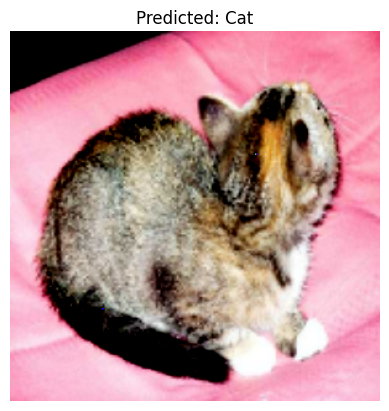

In [20]:
for image, label in val_ds.take(1):
    pred = model.predict(image[:1])
    plt.imshow(tf.cast(image[0] * 255.0, tf.uint8))  # Convert back to [0,255] for display
    plt.title(f"Predicted: {'Dog' if pred[0][0] > 0.5 else 'Cat'}")
    plt.axis('off')
    plt.show()
    break